<a href="https://colab.research.google.com/github/agneya23/Facial-Expression-Recognition/blob/main/FER%3A%20SOTA%20on%20FER2013/SOTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount the drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import Libraries
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

GPU


In [3]:
# Define Paths
dir_path = '/content/drive/MyDrive/AI_ML/Projects/FER/SOTA/'
data_path = dir_path + 'fer2013.csv'

In [4]:
# Prepare Dataframes
data_df = pd.read_csv(data_path)
train_data_df = data_df.iloc[:28708]
test_data_df = data_df.iloc[32298:]

In [5]:
# Define Transformations for Data Augmentation
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                        #torchvision.transforms.Normalize(mean=[0.445, 0.445, 0.445],std=[0.269, 0.269, 0.269]),
                                        torchvision.transforms.RandomApply([torchvision.transforms.RandomAffine(degrees=10, 
                                                                                                               translate=(0.2, 0.2), 
                                                                                                               scale=(0.8, 1.2))], 
                                                                           p=0.5)])

In [6]:
# Prepare Lists
train_lst = []
for i in range(0, len(train_data_df)):
    pixels = train_data_df.iloc[i]['pixels']
    emotion = train_data_df.iloc[i]['emotion']
    pixels_list = pixels.split()
    map_obj = map(int, pixels_list)
    pixels_list = list(map_obj)
    img_array = np.array(pixels_list, dtype=np.uint8)
    img_array = img_array.reshape([48, 48])
    img_array = torchvision.transforms.ToPILImage()(img_array)
    img_array = torchvision.transforms.functional.to_grayscale(img_array, num_output_channels=3)
    img = trans(img_array)
    train_lst.append( (img, emotion) )

test_lst = []
for i in range(0, len(test_data_df)):
    pixels = test_data_df.iloc[i]['pixels']
    emotion = test_data_df.iloc[i]['emotion']
    pixels_list = pixels.split()
    map_obj = map(int, pixels_list)
    pixels_list = list(map_obj)
    img_array = np.array(pixels_list, dtype=np.uint8)
    img_array = img_array.reshape([48, 48])
    img_array = torchvision.transforms.ToPILImage()(img_array)
    img_array = torchvision.transforms.functional.to_grayscale(img_array, num_output_channels=3)
    img = trans(img_array)
    test_lst.append( (img, emotion) )

torch.Size([3, 48, 48])


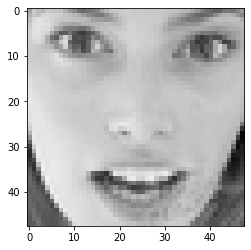

In [7]:
# Display Sample Image from the Data
img = train_lst[26][0].squeeze(0)
print(img.shape)
plt.imshow(img.permute(1,2,0))

In [8]:
# Create Dataloaders
train_loader = torch.utils.data.DataLoader(train_lst, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_lst, batch_size=1, shuffle=True)

In [9]:
# Define Model, Loss and Optimizer
model = torchvision.models.vgg16_bn(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad_ = True
model.fc = torch.nn.Linear(1000, 7)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9 , dampening=0, weight_decay=0.01, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

In [10]:
# Train and Evaluate the model
model.train()
best_train_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
num_epoch = 5
for i in range(num_epoch):
    total_train_loss, total_val_loss, train_loss, val_loss = 0, 0, 0, 0
    for train_images, train_labels in train_loader:
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        train_output = model(train_images)     
        train_loss = loss(train_output, train_labels)
        optimizer.zero_grad()
        train_loss.backward(retain_graph=False)
        optimizer.step()
        del train_images
        del train_labels
        total_train_loss += train_loss
    total_train_loss /= len(train_lst)
    scheduler.step(total_train_loss)

    print("The value of train loss at epoch {} is: {}".format(i+1, total_train_loss))

    if total_train_loss < best_train_loss:
        best_train_loss = total_train_loss
        best_model_wts = copy.deepcopy(model.state_dict())

print("The best train loss achieved is: {}".format(best_train_loss))

The value of train loss at epoch 1 is: 0.01568102464079857
The value of train loss at epoch 2 is: 0.010921327397227287
The value of train loss at epoch 3 is: 0.009243125095963478
The value of train loss at epoch 4 is: 0.007814256474375725
The value of train loss at epoch 5 is: 0.00614528451114893
The best train loss achieved is: 0.00614528451114893


In [11]:
model.load_state_dict(best_model_wts)
model.eval()
count = 0
# Make predictions on test data
for test_images, test_labels in test_loader:
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    test_output = model(test_images)
    test_output = test_output.argmax(1)
    if test_labels == test_output:
        count += 1
test_acc = count/len(test_lst) * 100
print("The accuracy achieved on the test data is: {}%".format(test_acc))

The accuracy achieved on the test data is: 55.25215937587071%
